<a href="https://colab.research.google.com/github/guyez/NLP/blob/main/IMDB_reviews_score_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminary Steps
These are some preliminary steps before addressing the task.
Import some basic libraries and set a variable that will be used in multiple steps.

In [ ]:
# The libraries we will use are imported here, in case of runtime problems
import os, shutil  #  file management
import sys
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation

In [ ]:
dataset_name = "aclImdb"

## Dataset Download
Dowload the Imdb movie reviews dataset


In [ ]:
import urllib.request  #  download files
import tarfile  #  unzip files

dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset_path = os.path.join(dataset_folder, "Movies.tar.gz")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

tar = tarfile.open(dataset_path)
tar.extractall(dataset_folder)
tar.close()
print("Successful extraction")

Successful extraction


## Create the dataframe
Now the dataset is loaded into a dataframe to be more accessible.
During the creation some data will be printed as an example.

In [ ]:
dataset_name = "aclImdb"

debug = True

dataframe_rows = []

for split in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        folder = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, split, sentiment)
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path):
                    # open the file
                    with open(file_path, mode='r', encoding='utf-8') as text_file:
                        # read it and extract informations
                        text = text_file.read()
                        score = filename.split("_")[1].split(".")[0]
                        file_id = filename.split("_")[0]

                        num_sentiment = -1

                        if sentiment == "pos" : num_sentiment = 1
                        elif sentiment == "neg" : num_sentiment = 0

                        # create single dataframe row
                        dataframe_row = {
                            "file_id": file_id,
                            "score": score,
                            "sentiment": num_sentiment,
                            "split": split,
                            "text": text
                        }

                        # print detailed info for the first file
                        if debug:
                            print(file_path)
                            print(filename)
                            print(file_id)
                            print(text)
                            print(score)
                            print(sentiment)
                            print(split)
                            print(dataframe_row)
                            debug = False
                        dataframe_rows.append(dataframe_row)

            except Exception as e:
                print('Failed to process %s. Reason: %s' % (file_path, e))
                sys.exit(0)

folder = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name)
if not os.path.exists(folder):
    os.makedirs(folder)

# transform the list of rows in a proper dataframe
dataframe = pd.DataFrame(dataframe_rows)
dataframe = dataframe[["file_id",
                       "score",
                       "sentiment",
                       "split",
                       "text"]]
dataframe_path = os.path.join(folder, dataset_name + ".pkl")
dataframe.to_pickle(dataframe_path)

/content/Datasets/Original/aclImdb/train/pos/5323_7.txt
5323_7.txt
5323
There are a number of things that are not correct, although this is not too important since what happened to whom and when is still in dispute. The most blatant liberty with the facts I think is when they start to play at Bruno Koschmidder's Kaiserkeller, when in fact they played at the Indra and moved to the Kaiserkeller later.<br /><br />I agree with Semprinni20 that the film was biased in favour of Pete Best's version, but if he is the story consultant then I guess he calls the shots. I also agree with Semprinni that the recordings Pete Best plays on say the last word on the subject of why he was fired.<br /><br />Although the film is not such a lavish production as the later film "Backbeat", I prefer this film because it is more accurate, and because it has a better script with deeper characterisation.<br /><br />There is plenty in the film that is quite substantial - such as Brian Epstein trying to hide the fa

Little analysis of the dataframe

In [ ]:
dataframe_path = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name, dataset_name + ".pkl")
df = pd.read_pickle(dataframe_path)

print("Dataframe structure:")
print(df)
print()


print("Total rows %d" % (len(df)))
print()

column = 'score'
print("Distribution of scores: ")
print(df[column].value_counts())
print()

column = 'sentiment'
print("Distribution of sentiment: ")
print(df[column].value_counts())
print()


for split in ["train", "test"]:
    df1 = df.loc[df['split'] == split]
    column = 'score'
    print("Distribution of scores in %s: " % (split))
    print(df1[column].value_counts())
    print()

##Preprocess

Apostrophes connecting words are used everywhere, especially in public reviews. To maintain uniform structure I converted them into standard lexicons. The text will then follow the rules of context free grammar and helps avoids any word-sense disambiguation.
I have found an apostrophe dictionary from user comments on analytics vidhy blog. 

In [ ]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [ ]:
import re
from nltk.stem.porter import PorterStemmer


def preprocessor(text):
  # Remove html tags
  text = re.sub('<[^>]*>', '', text)
  # Regex to find all the emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = text.lower()
  words = text.split()
  # Substitue apostrophes using the predefined dictionary
  split = [appos[word] if word in appos else word for word in words]
  text = " ".join(split)
  # Move all the emojis to the end of the sentence
  # This is so that the model can make use of the sequence of the text
  # and also ascertain the sentiment of the emojis at the end of the sentences.
  text = re.sub('[\W]+', ' ', text) + ' '.join(emoticons).replace('-', '')
  return text

porter = PorterStemmer()

def tokenizer_stemmer(text):
  # Perform a word-level preprocessing tasks using a PorterStemmer
  return[porter.stem(word) for word in text.split()]

In [ ]:
dataframe_path = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name, dataset_name + ".pkl")
df = pd.read_pickle(dataframe_path)

# select only the training sentences
df_train = df.loc[df['split'] == "train"]
train_corpus = df_train['text'].tolist()
Y_train = np.array(df_train['score'].astype('int').tolist())

# select only the test sentences
df_test = df.loc[df['split'] == "test"]
test_corpus = df_test['text'].tolist()
Y_test = np.array(df_test['score'].astype('int').tolist())

In [ ]:
example = train_corpus[0]
example

'There are a number of things that are not correct, although this is not too important since what happened to whom and when is still in dispute. The most blatant liberty with the facts I think is when they start to play at Bruno Koschmidder\'s Kaiserkeller, when in fact they played at the Indra and moved to the Kaiserkeller later.<br /><br />I agree with Semprinni20 that the film was biased in favour of Pete Best\'s version, but if he is the story consultant then I guess he calls the shots. I also agree with Semprinni that the recordings Pete Best plays on say the last word on the subject of why he was fired.<br /><br />Although the film is not such a lavish production as the later film "Backbeat", I prefer this film because it is more accurate, and because it has a better script with deeper characterisation.<br /><br />There is plenty in the film that is quite substantial - such as Brian Epstein trying to hide the fact that he has been "queer-bashed," only to find out that the band kn

In [ ]:
example_preprocessed = preprocessor(example)
example_preprocessed

'there are a number of things that are not correct although this is not too important since what happened to whom and when is still in dispute the most blatant liberty with the facts i think is when they start to play at bruno koschmidder s kaiserkeller when in fact they played at the indra and moved to the kaiserkeller later i agree with semprinni20 that the film was biased in favour of pete best s version but if he is the story consultant then i guess he calls the shots i also agree with semprinni that the recordings pete best plays on say the last word on the subject of why he was fired although the film is not such a lavish production as the later film backbeat i prefer this film because it is more accurate and because it has a better script with deeper characterisation there is plenty in the film that is quite substantial such as brian epstein trying to hide the fact that he has been queer bashed only to find out that the band knew he was gay all along little touches like the band

In [ ]:
example_stemmed = " ".join(tokenizer_stemmer(example_preprocessed))
example_stemmed

'there are a number of thing that are not correct although thi is not too import sinc what happen to whom and when is still in disput the most blatant liberti with the fact i think is when they start to play at bruno koschmidd s kaiserkel when in fact they play at the indra and move to the kaiserkel later i agre with semprinni20 that the film wa bias in favour of pete best s version but if he is the stori consult then i guess he call the shot i also agre with semprinni that the record pete best play on say the last word on the subject of whi he wa fire although the film is not such a lavish product as the later film backbeat i prefer thi film becaus it is more accur and becaus it ha a better script with deeper characteris there is plenti in the film that is quit substanti such as brian epstein tri to hide the fact that he ha been queer bash onli to find out that the band knew he wa gay all along littl touch like the band go into a café and order corn flake mit milch my favourit scene w

## Training and Testing


In [ ]:
"""from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# In practice I’ve found that using NLTK’s list actually decreases my performance because its too expansive,
# so I have suppllied my own list of words.
stop_words = ['in', 'of', 'at', 'a', 'the', 'for']


# Pipeline & Gridsearch setup
# TFIDF pipeline setup
tvc_pipe = Pipeline([
('tvec', TfidfVectorizer(tokenizer = tokenizer_stemmer, preprocessor = preprocessor, stop_words = stop_words)),
('lg', LogisticRegression(max_iter=1000))
])


# Fit
tvc_pipe.fit(train_corpus, Y_train)



# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
'tvec__max_df': [1.0, 0.4, 0.1],
'tvec__min_df': [1.0, 0.1, 0.00001],
'tvec__stop_words': [stop_words],
'tvec__max_features': [10000, 30000, 50000],
'tvec__ngram_range': [(1,1), (1, 2), (1,3)],
}
"""

In [ ]:
"""# Setting up GridSearch for TFIDFVectorizer
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)
# Fitting TVC GS
tvc_gs.fit(train_corpus, Y_train)"""

In [ ]:
#tvc_gs.best_params_

In [ ]:
# Definition of the vectorizer using the best params found
from sklearn.feature_extraction.text import  TfidfVectorizer

# In practice I’ve found that using NLTK’s list actually decreases my performance because its too expansive,
# so I have suppllied my own list of words.
stop_words = ['in', 'of', 'at', 'a', 'the', 'for']

vectorizer = TfidfVectorizer(tokenizer = tokenizer_stemmer,
                             preprocessor = preprocessor,
                             max_df= 0.4,
                             min_df= 1e-04,
                             stop_words = stop_words,
                             max_features = 30000,
                             ngram_range = (1, 3),
                             smooth_idf = False,
                             sublinear_tf= True)


X_train = vectorizer.fit_transform(train_corpus)

X_test = vectorizer.transform(test_corpus)

Our dataset is unbalanced (it has more samples for some scores than others). This can make the classifier biased toward the one or two scores with lost of samples, while dwarfing others that have less (i.e. the classifier learns the classes with more samples better and remains weak on the smaller classes).

There are various methods to do this. In this case I have chosen to use the SMOTE algorithm because seems to work well for the Logistic Regression classifier.

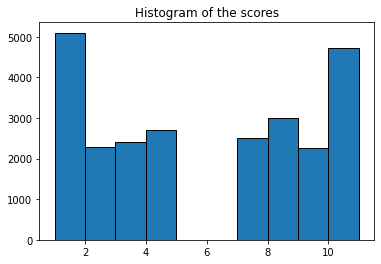

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(Y_train, edgecolor='k', bins = [1,2,3,4,5,6,7,8,9,10,11]) 
plt.title('Histogram of the scores')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

over = SMOTE()
X_train, Y_train = over.fit_resample(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


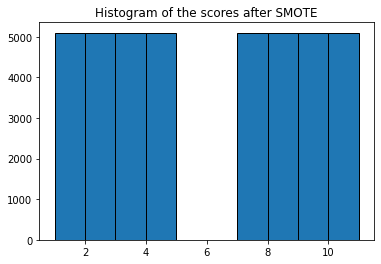

In [ ]:
plt.hist(Y_train, edgecolor='k', bins = [1,2,3,4,5,6,7,8,9,10,11]) 
plt.title('Histogram of the scores after SMOTE')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=1000)

classifier.fit(X_train, Y_train)

Y_pred_test = classifier.predict(X_test)
Y_pred_test_class = np.around(Y_pred_test)


## Test the results

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt


# task as regression

print("R2 score %f" % (r2_score(Y_test, Y_pred_test)))
print("MAE %f" % (mean_absolute_error(Y_test, Y_pred_test)))
print("MSE %f" % (mean_squared_error(Y_test, Y_pred_test)))
print()

# task as multiclass classification

report = classification_report(Y_test.astype('int'), Y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])
print(report)

confusion_matrix = confusion_matrix(Y_test.astype('int'), Y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])
print(confusion_matrix)
print()

# fancy confusion matrix
plot_confusion_matrix(classifier, X_test, Y_test, normalize='true', cmap=plt.cm.Blues, values_format=".2f")
